# 06. You Only Look Once

`YOLO` — это семейство моделей детектирования объектов, обладающие высокой скоростью и точностью. `YOLO` применяет единую нейронную сеть для предсказания ограничивающих рамок и классов объектов непосредственно из полного изображения за один проход.

## План

- Задача детектирования и классификации объектов
    * Общая формулировка
    * Параметризация прямоугольников
    * Задача сопоставления с `groundtruth` разметкой
    * Функция потерь
- Пакет  `Ultralytics` модель `YOLOv8`
- Собственная реализация`YOLOv8`
    * Параметризация прямоугольников
    * Задача сопоставления с `groundtruth` разметкой
    * Функция потерь



In [ ]:
import plotly.graph_objects as go
import torch.nn.functional  as F
import plotly.express       as px
import torch.nn             as nn
import numpy                as np
import scipy                as sp 

import argparse
import torch
import yaml
import math
import cv2
import os

from plotly.subplots  import make_subplots
from torch.utils.data import DataLoader
from torch            import Tensor
from typing           import Tuple
from tqdm             import trange

from PIL              import Image

torch.manual_seed(42)

## Модель `Ultralytics YOLO v8`

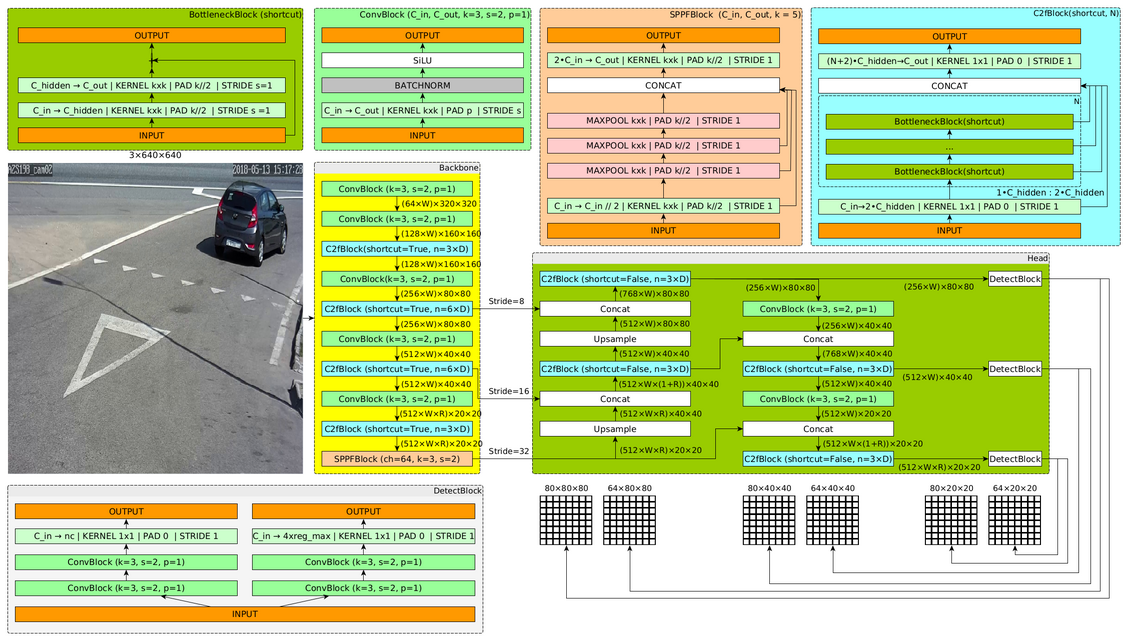

Импортируем модуль

In [ ]:
from ultralytics import YOLO

Загружаем модель

In [ ]:
model = YOLO("yolov8m.pt")
model.eval()
class_name_s = model.names

In [ ]:
#for name, module in model.named_modules():
#    print(name, module)

Загружаем тестовое изображение

In [ ]:
# Загрузка и подготовка изображения
image_path = "000001_gs198-02.jpg"
input_image   = cv2.imread(image_path)
input_image = cv2.resize(input_image, (640,640))
image_rgb   = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# Подготовка входного тензора для модели
input_image  = input_image.astype(np.float32) / 255.0
input_image  = np.transpose(input_image, (2, 0, 1))

input_tensor = torch.from_numpy(input_image).cuda()

Функция для визуализации результатов

In [ ]:
# Визуализация исходного изображения с помощью Plotly
def visualize_results_plotly(image, box_s=[], cls_s=[], conf_s=[], title=""):
    """
    Визуализация изображения с помощью Plotly
    """
    fig = go.Figure()
    
    # Добавляем изображение
    fig.add_trace(go.Image(z=image))
    # Добавляем детекции объектов
    for i, (box, cls, conf) in enumerate(zip(box_s, cls_s, conf_s)):
            x1, y1, x2, y2 = box
            # Добавляем bounding box
            fig.add_shape(
                type="rect",
                x0=x1, y0=y1, x1=x2, y1=y2,
                line=dict(color="red", width=3),
                fillcolor="rgba(255,0,0,0)"
                #name=class_names[int(class_id)] if class_names else f"Class {class_id}"
            )
            # Добавляем class и confidence
            fig.add_annotation(
             x=x1, y=y1, text=f'{class_name_s[round(cls)]} ({conf:.2f})',
             showarrow=False,
             bgcolor='black',
             bordercolor='black',
             borderwidth=2,
             font=dict(size=12, color="white")
            )
    
    # Настраиваем макет
    height, width = image.shape[:2]
    fig.update_layout(
        title=title,
        xaxis=dict(visible=False, range=[0, width]),
        yaxis=dict(visible=False, range=[height, 0], scaleanchor="x"),
        width=width,
        height=height,
        margin=dict(l=0, r=0, t=40, b=0)
    )
    
    fig.show()


In [ ]:
visualize_results_plotly(image_rgb, title="Исходное изображение и детекции объектов")

Обработаем изображение посредством модели `Ultralytics YOLO v8`

In [ ]:
output_data = model(input_tensor.unsqueeze(0))[0]

xyxy_s  = output_data.boxes.xyxy.cpu().detach().numpy()
cls_s   = output_data.boxes.cls .cpu().detach().numpy()
conf_s  = output_data.boxes.conf.cpu().detach().numpy()
# Визуализируем исходное изображение
visualize_results_plotly(image_rgb, xyxy_s, cls_s,conf_s, title="Исходное изображение и детекции объектов")

In [ ]:
boxes = output_data[0].boxes
boxes

Обработаем изображение посредством нашей модели `YOLO v8` и сохраним промежуточные буферы

In [ ]:
#Имена буферов ветки детектирования объектов и классификации объектов
det_layer_name_s = [
 "model.22.cv2.0.2",
 "model.22.cv2.1.2",
 "model.22.cv2.2.2"    
]

cls_layer_name_s = [
 "model.22.cv3.0.2",
 "model.22.cv3.1.2",
 "model.22.cv3.2.2"
]

In [ ]:
def get_model_output(input_tensor, model, cls_layer_name_s, det_layer_name_s):
    # Получение выходов с конкретных слоев
    def get_layers_output(model, layer_name_s):
        result_output_s = dict()
    
        def get_activation(name):
            def hook(module, input, output):
                result_output_s[name] = output
            return hook
        # Поиск слоев по имени
        handle_s = []
        for name, module in model.named_modules():
            if name in layer_name_s:
                handle_s.append( module.register_forward_hook(get_activation(name)) )
           
        # Проход вперед
        with torch.no_grad():
            model(input_tensor.unsqueeze(0))
        
        # Удаление хуков
        [ handle.remove() for handle in handle_s ]
    
        return result_output_s
    # Получение буферов с ветвей классификации объекта
    cls_layer_output_s = get_layers_output(model.model, cls_layer_name_s)
    # Получение буферов с ветвей детекции объекта
    det_layer_output_s = get_layers_output(model.model, det_layer_name_s)
    # Постпроцессинг буферов
    output_data_s = []
    for cls_layer_name, det_layer_name in zip(cls_layer_name_s, det_layer_name_s):
        output_data_s. append( (cls_layer_output_s[cls_layer_name][0], det_layer_output_s[det_layer_name][0]) )
    return output_data_s

output_data_s = get_model_output(input_tensor, model, cls_layer_name_s, det_layer_name_s)

for output_data in output_data_s:
    print(output_data[0].shape, output_data[1].shape )

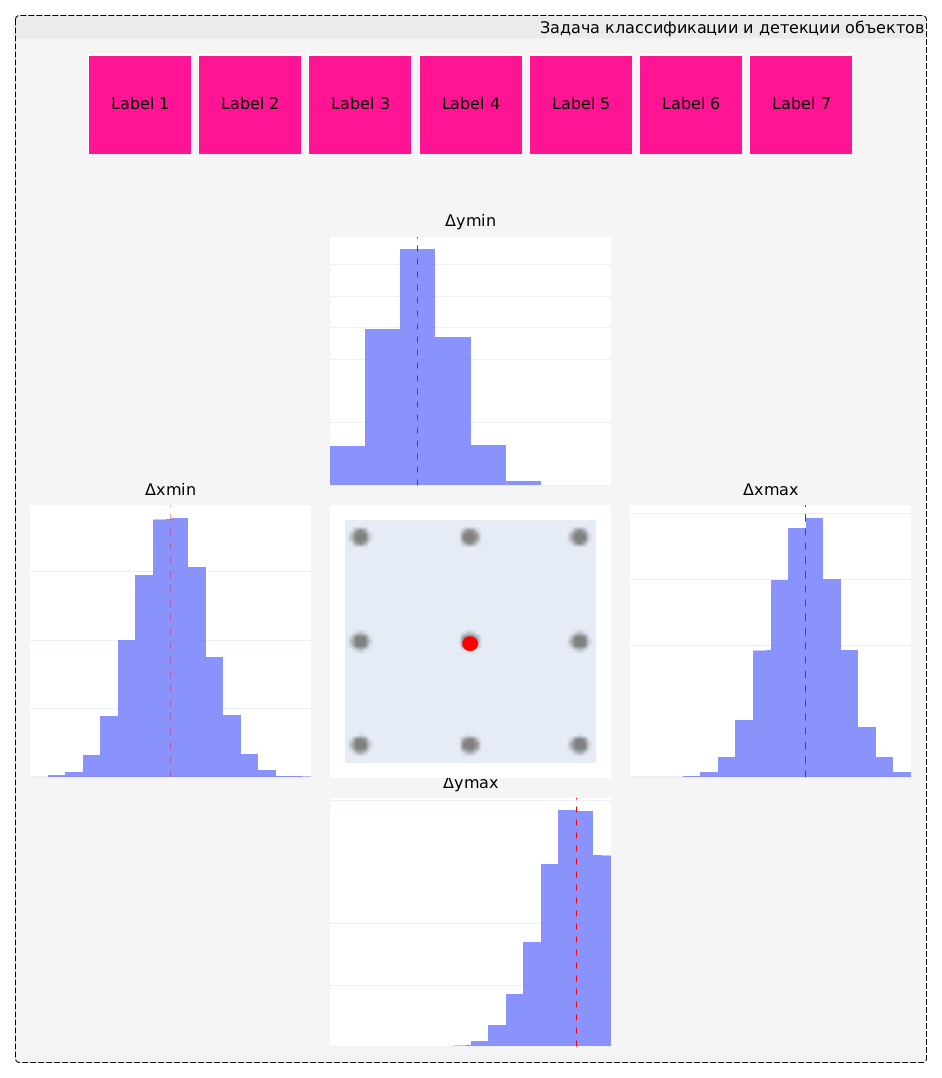

In [ ]:
def process_outputs( output_data_s, stride_s = [8, 16, 32], threshold = 0.5 ):
    def make_anchors(feature_map_height, feature_map_width, stride, grid_cell_offset=0.5):
        """
        Сгенерировать сетку цетров детекции
        """
        anchor_points, stride_tensor = [], []
        
        x_s      = torch.arange(end=feature_map_width ) + grid_cell_offset  # shift x
        y_s      = torch.arange(end=feature_map_height) + grid_cell_offset  # shift y
        y_s, x_s = torch.meshgrid(y_s, x_s)
               
        return torch.stack((x_s, y_s))
    
    def decode_boxes(feature_map, stride, reg_max=16):
        """
        Декодирование bounding boxes из распределения
        """
        depth, height, width = feature_map.shape
        device = feature_map.device
        dtype  = feature_map.dtype
        
        anchor_xy_s = make_anchors(height, width, stride).to(device)
        
        p_s = torch.softmax( feature_map.view(4, depth // 4, height, width), dim=1 )
        delta_xyxy_s = torch.einsum('ijkm,j->ikm', p_s, torch.arange(reg_max, device=device, dtype=dtype))

        lt_xy_s = (anchor_xy_s - delta_xyxy_s[:2,:,:])*stride
        rb_xy_s = (anchor_xy_s + delta_xyxy_s[2:,:,:])*stride
        
        xyxy_s = torch.cat((lt_xy_s, rb_xy_s), dim=0)
        return xyxy_s
    
    
    class_ss, xyxy_ss, conf_ss = [], [], []
    for i, ((cls_data, det_data), stride)  in enumerate(zip(output_data_s, stride_s)):
        conf_data = torch.sigmoid(cls_data)
        xyxy_s    = decode_boxes(det_data, stride )
        
        mask_data   = conf_data > threshold
        index_ss    = torch.nonzero(mask_data)

        conf_s  = conf_data[mask_data]
        class_s = index_ss[:,0] #Получить индексы классов
        i_s     = index_ss[:,1]
        j_s     = index_ss[:,2] 
                
        xyxy_ss .append( xyxy_s[:,i_s, j_s].transpose(0,1) )
        class_ss.append( class_s )
        conf_ss .append( conf_s )

    return torch.cat(class_ss), torch.cat(conf_ss), torch.cat( xyxy_ss, axis=0)

class_s, conf_s, xyxy_s = process_outputs( output_data_s )

xyxy_s  = xyxy_s .cpu().detach().numpy()
class_s = class_s.cpu().detach().numpy()
conf_s  = conf_s .cpu().detach().numpy()

visualize_results_plotly(image_rgb, xyxy_s, class_s, conf_s, title="Исходное изображение и детекции объектов")

## Ключевые блоки модели `YOLOv8`

### `YOLOv8Backbone` часть модели

In [ ]:
# Общие параметры модели YOLOv8 nano
d, w, r = 0.33, 0.25, 2.0

#### `Convolutional` блок

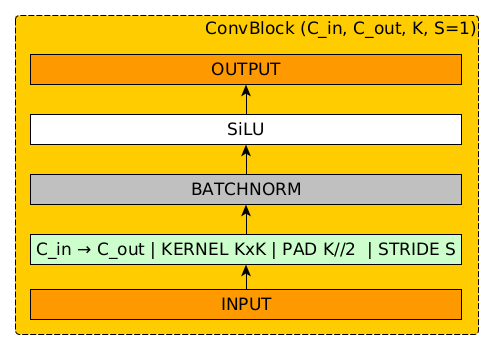

In [ ]:
class Conv(nn.Module):
    """Стандартная свертка YOLOv8 (Conv2d + BatchNorm2d + SiLU)"""
    def __init__(self, in_ch, out_ch, kernel = 3, stride = 2, padding = 1):
        super().__init__()
        self.conv = nn.Conv2d( in_ch, out_ch, kernel, stride, padding, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.SiLU(inplace=True)
    
    def forward(self, x: Tensor) -> Tensor:
        return self.act(self.bn(self.conv(x)))

In [ ]:
x = torch.randn(1, 3, 640, 640)
w = 0.25
y = Conv(3, int(64*w))(x)

assert y.shape == (1, 16, 320, 320)

#### `Spatial Pyramid Pooling Fast` блок

`SPPF` агрегирует признаки на разных масштабах посредством `MaxPooling` с разными размерами окна, после чего объединяет их.

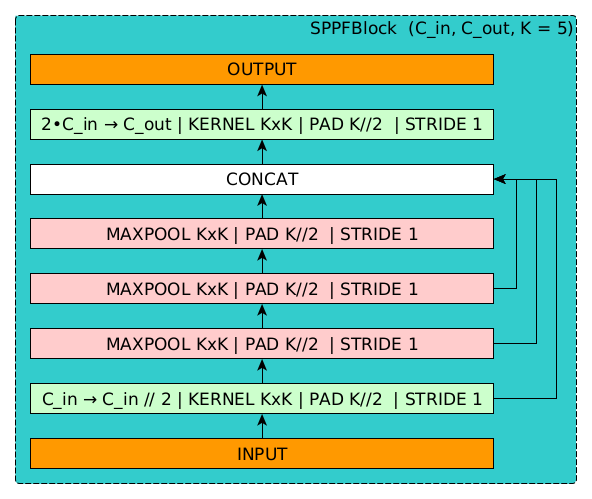

In [ ]:
class SPPF(nn.Module):
    """Быстрый Spatial Pyramid Pooling"""
    def __init__(self, in_ch, out_ch):
        super().__init__()

        kernel = 5
        
        mid_ch     = in_ch // 2
        self.conv1 = Conv(in_ch     , mid_ch, kernel = 1, stride = 1, padding = 0)
        self.conv2 = Conv(mid_ch * 4, out_ch, kernel = 1, stride = 1, padding = 0)
        self.pool  = nn.MaxPool2d(kernel, 1, kernel//2)
    
    def forward(self, x: Tensor) -> Tensor:
        x  = self.conv1(x )
        y1 = self.pool (x )
        y2 = self.pool (y1)
        y3 = self.pool (y2)
        return self.conv2(torch.cat([x, y1, y2, y3], 1))

In [ ]:
n_ch = int(512*w*r)

x = torch.randn(1, n_ch, 20, 20)

y = SPPF(n_ch, n_ch)(x)

assert y.shape == (1, n_ch, 20, 20)

#### `Bottleneck` блок

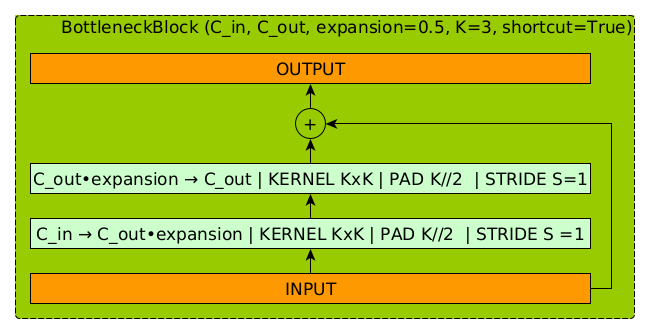

In [ ]:
class Bottleneck(nn.Module):
    """Базовый блок ResNet (с остаточным соединением)"""
    def __init__(self, in_ch, out_ch, shortcut: bool = True):
        super().__init__()
        self.shortcut = shortcut
        
        self.conv1 = Conv(in_ch, out_ch,  kernel = 3, stride = 1, padding = 1)
        self.conv2 = Conv(in_ch, out_ch,  kernel = 3, stride = 1, padding = 1)
    
    def forward(self, x: Tensor) -> Tensor:
        if self.shortcut:
            return x + self.conv2(self.conv1(x))
        else:
            return self.conv2(self.conv1(x))

In [ ]:
x = torch.randn(1, 10, 20, 20)

y = Bottleneck(10, 10)(x)

assert y.shape == (1, 10, 20, 20)

#### `C2f` блок

Блок `C2f` делит входные признаки на две ветви, пропускает одну напрямую, а вторую — через последовательность `Bottleneck`-блоков, после чего конкатенирует их и применяет `1×1` свёртку для объединения.

Так достигаются:
- Глубокие представления признаков
- Эффективная передача информации (через частичное разделение потоков)

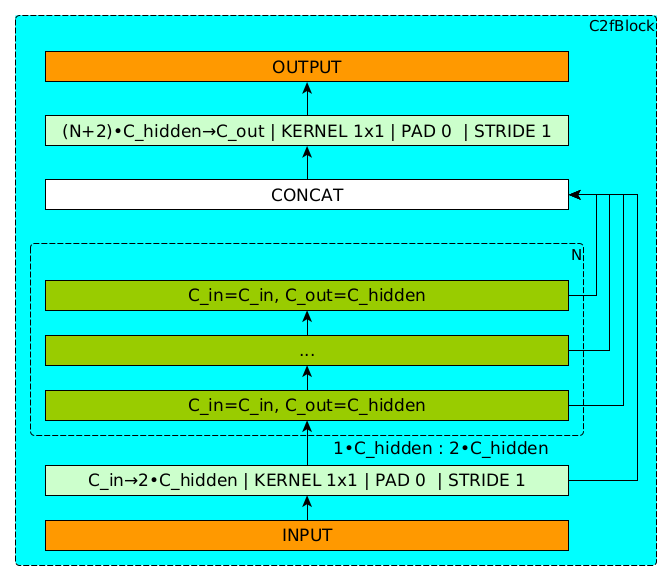

In [ ]:
class C2f(nn.Module):
    """Модифицированный CSP-блок с несколькими Bottleneck"""
    def __init__(self, in_ch, out_ch, n=1, shortcut=False):
        super().__init__()

        self.hid_ch = int(0.5*out_ch)
        
        self.conv1 = Conv(in_ch, out_ch, kernel=1, stride=1, padding=0)
        self.bottlenecks = nn.ModuleList(Bottleneck(self.hid_ch, self.hid_ch, shortcut=shortcut) for _ in range(n))
        self.conv2 = Conv((n+2)*self.hid_ch, out_ch, kernel=1, stride=1, padding=0)

    def forward(self, x:torch.Tensor):
        module_outputs = list(self.conv1(x).chunk(2, dim=1))
        module_outputs.extend(b(module_outputs[-1]) for b in self.bottlenecks)
        return self.conv2(torch.cat(module_outputs, dim=1))


In [ ]:
x = torch.randn(1, 10, 20, 20)

y = C2f(10, 10)(x)

assert y.shape == (1, 10, 20, 20)

In [ ]:
# Общие параметры модели YOLOv8 nano
d, w, r = 1/3, 1/4, 2

### Реализация блока

In [ ]:
class YOLOv8Backbone(nn.Module):
    """
    Backbone сеть для YOLOv8 на основе архитектуры CSPDarknet
    
    Args:
        d:
        w:
        r:
    """
    def __init__(self, d, w, r):
        super().__init__()
        
        # Базовые каналы
        base_channels = round(64 * w)
        base_depth    = round( 3 * d)
        
        # Расчет количества каналов для каждого этапа
        ch0 = base_channels * 1   #   64
        ch1 = base_channels * 2   #  128
        ch2 = base_channels * 4   #  256
        ch3 = base_channels * 8   #  512
        ch4 = round(base_channels * 8*r) # 1024
        
        # Расчет глубины для каждого этапа
        d0 = base_depth * 1  # 1
        d1 = base_depth * 1  # 1
        d2 = base_depth * 2  # 2
        d3 = base_depth * 2  # 2
        d4 = base_depth * 1  # 1

        # Этап 0: /4 разрешение
        self.stage_0 = nn.Sequential(
         Conv(  3, ch0, kernel=3, stride=2, padding=1),  # /2
         Conv(ch0, ch1, kernel=3, stride=2, padding=1),  # /4
         C2f (ch1, ch1, n=d0, shortcut=True)
        )
        # Этап 1: /8 разрешение
        self.stage_1 = nn.Sequential(
         Conv(ch1, ch2, kernel=3, stride=2, padding=1),  # /8, 128 -> 256
         C2f (ch2, ch2, n=d1, shortcut=True)  # 256 -> 256
        )
        # Этап 2: /16 разрешение
        self.stage_2 = nn.Sequential(
         Conv(ch2, ch3, kernel=3, stride=2, padding=1), # /16, 256 -> 512
         C2f(ch3, ch3, n=d2, shortcut=True)             # 512 -> 512
        )
        # Этап 3: /32 разрешение
        self.stage_3 = nn.Sequential(
         Conv(ch3, ch4, kernel=3, stride=2, padding=1),  # /32, 512 -> 1024
         C2f (ch4, ch4, n=d3, shortcut=True),  # 1024 -> 1024
         SPPF(ch4, ch4)
        )
        
    def forward(self, x):
        """
        Прямой проход через backbone сеть
        
        Args:
            x (Tensor): Входное изображение [B, 3, H, W]
            
        Returns:
            list: Список feature maps для neck сети [P3, P4, P5]
        """
        # Этап 0: /4 разрешение
        x  = self.stage_0(x)
        # Этап 1: /8 разрешение
        x  = self.stage_1(x)  
        p3 = x
        # Этап 2: /16 разрешение
        x  = self.stage_2(x)
        p4 = x 
        # Этап 3: /32 разрешение
        x = self.stage_3(x)  # Уменьшаем разрешение до /32
        p5 = x
        return [p3, p4, p5]

In [ ]:
# Тестовый вход (3x640x640)
x = torch.randn(1, 3, 640, 640)
# Создаем backbone отдельно
backbone = YOLOv8Backbone(d, w, r)
y_s = backbone(x)

assert y_s[0].shape == (1,  64, 80, 80)
assert y_s[1].shape == (1, 128, 40, 40)
assert y_s[2].shape == (1, 256, 20, 20)

### `YOLOv8Head` часть модели

#### `Detect` блок

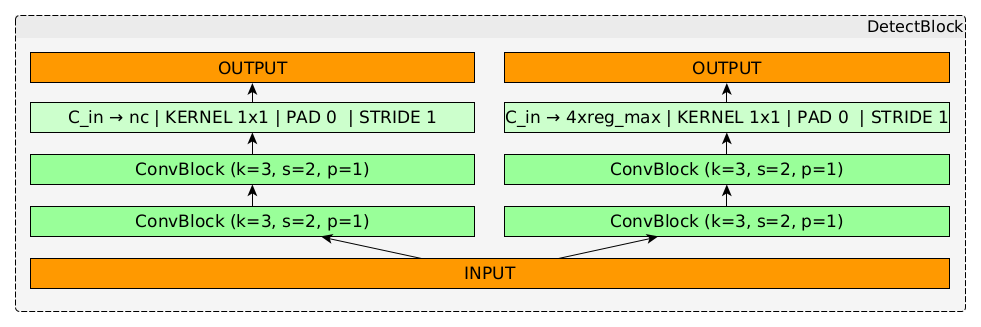

In [ ]:
class Detect(nn.Module):
    """Детекционная голова YOLOv8"""
    def __init__(self, in_ch, num_classes, reg_max):
        super().__init__()
        self.num_classes = num_classes
        self.reg_max     = reg_max
        
        c2 = in_ch
        c3 = in_ch
            
        self.box_conv_s = nn.Sequential(
         Conv     (in_ch,             c2, kernel=3, stride=2, padding=1),
         Conv     (   c2,             c2, kernel=3, stride=1, padding=1),
         nn.Conv2d(   c2, 4*self.reg_max, kernel_size=1)
        )

        self.cls_conv_s = nn.Sequential(
         Conv     (in_ch,   c3, kernel=3, stride=2, padding=1),
         Conv     (   c3,   c3, kernel=3, stride=1, padding=1),
         nn.Conv2d(   c3, self.num_classes, kernel_size=1)
        )
        
    
    def forward(self, x):
        outputs = []

        box_output = self.box_conv_s(x)
        cls_output = self.cls_conv_s(x)
               
        return box_output, cls_output

In [ ]:
# Тестовый вход (3x640x640)
in_ch       = round(256*w)
num_classes = 80
reg_max     = 16

x           = torch.randn(1, in_ch, 80, 80)
# Создаем backbone отдельно
detect = Detect(in_ch, num_classes, reg_max)

box_output, cls_output = detect(x)

print(box_output.shape, cls_output.shape)

#### Реализация блока

In [ ]:
class YOLOv8Head(nn.Module):
    """
    Сеть агрегации путей (PAN) для YOLOv8
    
    Args:
        channels   (list): Список количества каналов для каждого уровня features
        num_classes (int): Количество классов для детекции
    """
    def __init__(self, depth, width, ratio, reg_max=16, num_classes=80):
        super().__init__()
        
        # Top-down path (путь сверху-вниз) - передача семантической информации
        # Upsample слои для увеличения разрешения
        self.upsample_p5    = nn.Upsample(scale_factor=2, mode='nearest')
        self.c2f1           = C2f(round(512*width*(1 + ratio)), round(512*w), n=round(3*depth))  # Обработка объединенных features P5 и P4
        
        self.upsample_p4    = nn.Upsample(scale_factor=2, mode='nearest')
        self.c2f2           = C2f(round(768*width), round(256*width), n=round(3*depth))  # Обработка объединенных features P4 и P3
        
        # Bottom-up path (путь снизу-вверх) - передача позиционной информации
        # Downsample слои для уменьшения разрешения
        self.conv_downsample1 = Conv( round(256*width), round(256*w), kernel=3, stride=2, padding=1)  # Downsample P3
        self.c2f3 = C2f(round(768*width), round(512*width), n=round(3*depth))  # Обработка объединенных features P3 и P4
        
        self.conv_downsample2 = Conv( round(512*width), round(512*w), kernel=3, stride=2, padding=1)  # Downsample P4
        self.c2f4 = C2f(round(512*width*(1+ratio)), round(512*width*ratio), n=round(3*depth))  # Обработка объединенных features P4 и P5
        
        # Detection heads для каждого уровня детекции
        self.detect_s = nn.ModuleList([
         Detect( 64, num_classes, reg_max),  # P3/8  - малые объекты
         Detect(128, num_classes, reg_max),  # P4/16 - средние объекты
         Detect(256, num_classes, reg_max)   # P5/32 - большие объекты
        ])

    def forward(self, features):
        """
        Прямой проход через PAN neck
        
        Args:
            features (list): Список feature maps от backbone [P3, P4, P5]
            
        Returns:
            list: Список feature maps для detection head
        """
        # Разделяем features по уровням
        p3, p4, p5 = features
        
        # Top-down pathway (путь сверху-вниз)
        
        # Увеличиваем P5 и объединяем с P4
        p5_upsampled = self.upsample_p5(p5)
        p4_combined  = torch.cat([p5_upsampled, p4], dim=1)  # Объединяем P5 и P4
        p4_processed = self.c2f1(p4_combined)  # Обрабатываем объединенные features
        
        # Увеличиваем P4 и объединяем с P3
        p4_upsampled       = self.upsample_p4(p4_processed)
        p3_combined        = torch.cat([p4_upsampled, p3], dim=1)  # Объединяем P4 и P3
        p3_processed       = self.c2f2(p3_combined)  # Обрабатываем объединенные features
        p3_processed_final = p3_processed
        
        # Bottom-up pathway (путь снизу-вверх)
        # Уменьшаем P3 и объединяем с P4
        p3_downsampled     = self.conv_downsample1(p3_processed)  # Уменьшаем разрешение P3
        p3_p4_combined     = torch.cat([p3_downsampled, p4_processed], dim=1)  # Объединяем P3 и P4
        p4_processed_final = self.c2f3(p3_p4_combined)  # Обрабатываем объединенные features
        
        # Уменьшаем P4 и объединяем с P5
        p4_downsampled     = self.conv_downsample2(p4_processed_final)  # Уменьшаем разрешение P4
        p4_p5_combined     = torch.cat([p4_downsampled, p5], dim=1)  # Объединяем P4 и P5
        p5_processed_final = self.c2f4(p4_p5_combined)  # Обрабатываем объединенные features

        # Возвращаем обработанные feature maps для детекции
        return [
         self.detect_s[0](p3_processed_final), # P3 - малые объекты
         self.detect_s[1](p4_processed_final), # P4 - средние объекты
         self.detect_s[2](p5_processed_final)  # P5 - большие объекты
        ]

In [ ]:
# Создаем тестовые данные - feature maps от backbone сети
input_s = [
 torch.randn(1,  64, 80, 80),  # P3
 torch.randn(1, 128, 40, 40),  # P4
 torch.randn(1, 256, 20, 20)   # P5
]

# Создаем экземпляр PANNeck
head = YOLOv8Head(d, w, r, reg_max=16, num_classes=80)

# Пропускаем features через neck
output_s = head(input_s)

assert output_s[0][0].shape == (1,   64, 40, 40)
assert output_s[0][1].shape == (1,   80, 40, 40)

assert output_s[1][0].shape == (1,  64, 20, 20)
assert output_s[1][1].shape == (1,  80, 20, 20)

assert output_s[2][0].shape == (1,  64, 10, 10)
assert output_s[2][1].shape == (1,  80, 10, 10)

## Модель YOLOv8

In [ ]:
class YOLOv8(nn.Module):
    """Полная модель YOLOv8"""
    def __init__(self, depth = 1/3, width = 1/4, ratio = 2, num_classes=80, ):
        super().__init__()
        self.num_classes = num_classes
        
        # Инициализируем backbone
        self.backbone = YOLOv8Backbone(depth, width, ratio)
        
        # Инициализируем neck с detection heads
        self.head = YOLOv8Head(depth, width, ratio, num_classes)
        
    def forward(self, x):
        # Получаем features из backbone
        features = self.backbone(x)
        
        # Пропускаем через neck
        output_s = self.head(features)
        
        return output_s

In [ ]:
def decode_predictions(output_s, num_classes, conf_threshold=0.25, iou_threshold=0.45):
    """
    Декодирует выходы модели в детекции
    
    Args:
        outputs: Выходы модели
        conf_threshold: Порог уверенности для фильтрации
        iou_threshold: Порог IoU для NMS
        
    Returns:
        list: Список детекций для каждого изображения в батче
    """
    batch_detections = []
    batch_size = output_s[0].shape[0]
    
    for i in range(batch_size):
        # Собираем все предсказания для одного изображения
        detections = []
        
        for level, output in enumerate(output_s):
            # output shape: [batch, num_classes + 4*reg_max, H, W]
            level_output = output[i]  # [num_classes + 4*reg_max, H, W]
            
            # Разделяем на классы и регрессию bbox
            cls_pred = level_output[:self.num_classes]  # [num_classes, H, W]
            reg_pred = level_output[self.num_classes:]  # [4*reg_max, H, W]
            
            # Reshape регрессии: [4*reg_max, H, W] -> [4, reg_max, H, W]
            reg_pred = reg_pred.view(4, self.reg_max, *reg_pred.shape[1:])
            
            # Декодируем bbox с помощью DFL
            bbox_pred = torch.einsum('cmnh->mnh', reg_pred.softmax(dim=1) * self.proj[None, :, None, None])
            
            # Применяем sigmoid к предсказаниям классов
            cls_pred = torch.sigmoid(cls_pred)
            
            # Получаем размеры feature map
            H, W = cls_pred.shape[1:]
            
            # Создаем сетку координат
            yv, xv = torch.meshgrid([torch.arange(H), torch.arange(W)], indexing='ij')
            grid = torch.stack((xv, yv), 2).to(cls_pred.device).float()
            
            # Масштабируем координаты в соответствии с уровнем feature map
            stride = 8 * (2 ** level)  # P3:8, P4:16, P5:32
            
            # Декодируем bbox координаты
            bbox_pred = bbox_pred.permute(1, 2, 0)  # [H, W, 4]
            bbox_pred[..., :2] = (bbox_pred[..., :2] * 2 - 0.5 + grid) * stride
            bbox_pred[..., 2:] = (bbox_pred[..., 2:] * 2) ** 2 * stride
            
            # Преобразуем в формат [x1, y1, x2, y2]
            x1y1 = bbox_pred[..., :2] - bbox_pred[..., 2:] / 2
            x2y2 = bbox_pred[..., :2] + bbox_pred[..., 2:] / 2
            bboxes = torch.cat([x1y1, x2y2], dim=-1)  # [H, W, 4]
            
            # Reshape в [H*W, 4]
            bboxes = bboxes.view(-1, 4)
            
            # Reshape предсказаний классов в [H*W, num_classes]
            cls_pred = cls_pred.permute(1, 2, 0).view(-1, self.num_classes)
            
            # Фильтруем по confidence threshold
            max_conf, max_idx = cls_pred.max(dim=1)
            mask = max_conf > conf_threshold
            
            if mask.any():
                bboxes = bboxes[mask]
                scores = max_conf[mask]
                class_ids = max_idx[mask]
                
                # Добавляем детекции
                for j in range(bboxes.shape[0]):
                    detections.append({
                        'bbox': bboxes[j].cpu().numpy(),
                        'score': scores[j].item(),
                        'class_id': class_ids[j].item()
                    })
        
        # Применяем NMS к детекциям
        if detections:
            # Преобразуем в тензоры для NMS
            bboxes = torch.tensor([d['bbox'] for d in detections])
            scores = torch.tensor([d['score'] for d in detections])
            
            # Применяем NMS
            keep = torch.ops.torchvision.nms(bboxes, scores, iou_threshold)
            
            # Сохраняем только отфильтрованные детекции
            detections = [detections[i] for i in keep]
        
        batch_detections.append(detections)
    
    return batch_detections

## Функция потерь YOLOv8: Подробный обзор

### Метрика `IoU` vs. `CIoU` (`GIoU` и `DIoU`)

$$
\begin{array}{|c|c|c|c|}
\hline
\textbf{IoU} & \textbf{GIoU} & \textbf{DIoU} & \textbf{CIoU} \\
\hline
\displaystyle \frac{|B \cap B^{gt}|}{|B \cup B^{gt}|} 
&
\displaystyle \text{IoU} - \frac{|C \setminus (B \cup B^{gt})|}{|C|} 
&
\displaystyle \text{IoU} - \frac{\rho^2(\mathbf{b}, \mathbf{b}^{gt})}{c^2} 
&
\displaystyle \text{IoU} - \frac{\rho^2(\mathbf{b}, \mathbf{b}^{gt})}{c^2} - \alpha v,\;\;
v = \frac{4}{\pi^2}\!\left(\arctan\frac{w^{gt}}{h^{gt}} - \arctan\frac{w}{h}\right)^2,\;\;
\alpha = \frac{v}{(1-\text{IoU})+v}
\\
\hline
\end{array}
$$

Представим ситуацию, где у нас есть ground truth bounding box и два разных predicted bounding box:

- `Ground Truth`: [50, 50, 150, 150] 
- `Prediction A`: [60, 60, 160, 160] 
- `Prediction B`: [50, 50, 140, 160] 

In [ ]:
def calculate_iou(bboxes1, bboxes2, eps=1e-7):
    """
    Calculate IoU between two batches of bounding boxes.
    Shapes: bboxes1 (M, 4), bboxes2 (N, 4) -> Returns (M, N)
    """
    # Expand dimensions to compute pairwise IoU
    bboxes1 = bboxes1.unsqueeze(1)  # Shape: (M, 1, 4)
    bboxes2 = bboxes2.unsqueeze(0)  # Shape: (1, N, 4)
    
    # Intersection coordinates
    inter_x1 = torch.maximum(bboxes1[..., 0], bboxes2[..., 0])
    inter_y1 = torch.maximum(bboxes1[..., 1], bboxes2[..., 1])
    inter_x2 = torch.minimum(bboxes1[..., 2], bboxes2[..., 2])
    inter_y2 = torch.minimum(bboxes1[..., 3], bboxes2[..., 3])
    
    # Intersection area
    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)
    
    # Box areas
    area1 = (bboxes1[..., 2] - bboxes1[..., 0]) * (bboxes1[..., 3] - bboxes1[..., 1])
    area2 = (bboxes2[..., 2] - bboxes2[..., 0]) * (bboxes2[..., 3] - bboxes2[..., 1])
    
    # Union area
    union_area = area1 + area2 - inter_area + eps
    
    return inter_area / union_area

def calculate_ciou(bboxes1, bboxes2, eps=1e-7):
    """
    Calculate Complete IoU between two batches of bounding boxes.
    Shapes: bboxes1 (M, 4), bboxes2 (N, 4) -> Returns (M, N)
    """
    iou = calculate_iou(bboxes1, bboxes2, eps)
    
    # Center points
    center_x1 = (bboxes1[:, 0] + bboxes1[:, 2]) / 2
    center_y1 = (bboxes1[:, 1] + bboxes1[:, 3]) / 2
    center_x2 = (bboxes2[:, 0] + bboxes2[:, 2]) / 2
    center_y2 = (bboxes2[:, 1] + bboxes2[:, 3]) / 2
    
    # Center distance (M, N)
    center_distance = (
        (center_x1.unsqueeze(1) - center_x2.unsqueeze(0)) ** 2 +
        (center_y1.unsqueeze(1) - center_y2.unsqueeze(0)) ** 2
    )
    
    # Enclosing box diagonal distance
    enclose_x1 = torch.minimum(bboxes1[:, 0].unsqueeze(1), bboxes2[:, 0].unsqueeze(0))
    enclose_y1 = torch.minimum(bboxes1[:, 1].unsqueeze(1), bboxes2[:, 1].unsqueeze(0))
    enclose_x2 = torch.maximum(bboxes1[:, 2].unsqueeze(1), bboxes2[:, 2].unsqueeze(0))
    enclose_y2 = torch.maximum(bboxes1[:, 3].unsqueeze(1), bboxes2[:, 3].unsqueeze(0))
    enclose_diagonal = (enclose_x2 - enclose_x1) ** 2 + (enclose_y2 - enclose_y1) ** 2 + eps
    
    # Aspect ratio consistency term (v)
    w1 = bboxes1[:, 2] - bboxes1[:, 0]
    h1 = bboxes1[:, 3] - bboxes1[:, 1]
    w2 = bboxes2[:, 2] - bboxes2[:, 0]
    h2 = bboxes2[:, 3] - bboxes2[:, 1]
    
    v = (4 / (math.pi ** 2)) * (
        torch.atan(w2.unsqueeze(0) / (h2.unsqueeze(0) + eps)) - 
        torch.atan(w1.unsqueeze(1) / (h1.unsqueeze(1) + eps))
    ) ** 2
    
    # Alpha parameter
    alpha = v / (1 - iou + v + eps)
    
    # CIoU calculation
    ciou = iou - (center_distance / enclose_diagonal) - (alpha * v)
    
    return ciou

# Example usage
gt_boxes = torch.tensor([[50., 50., 150., 150.]])  # Ground truth (1,4)
pred_boxes = torch.tensor([
    [60., 60., 160., 160.],  # Prediction A
    [50., 50., 140., 160.]   # Prediction B
])  # Shape: (2,4)

iou  = calculate_iou (gt_boxes, pred_boxes)
ciou = calculate_ciou(gt_boxes, pred_boxes)

print(f"IoU values:  {iou .squeeze().tolist()}")
print(f"CIoU values: {ciou.squeeze().tolist()}")

In [ ]:
gt_box = gt_boxes  [0]
pred_a = pred_boxes[0]
pred_b = pred_boxes[1]

# Create visualization with Plotly
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(f"Предсказание A: IoU={iou[0][0]:.3f}, CIoU={ciou[0][0]:.3f}", 
                    f"Предсказание B: IoU={iou[0][1]:.3f}, CIoU={ciou[0][1]:.3f}"),
    horizontal_spacing=0.1
)

# Function to create a rectangle shape
def create_rectangle(x0, y0, x1, y1, color, name, dash=None):
    return go.Scatter(
        x=[x0, x1, x1, x0, x0],
        y=[y0, y0, y1, y1, y0],
        fill="toself",
        fillcolor=color,
        line=dict(color=color, width=2, dash=dash),
        mode="lines",
        name=name,
        opacity=0.6
    )

# Add shapes for Prediction A
fig.add_trace(create_rectangle(gt_box[0], gt_box[1], gt_box[2], gt_box[3], "green", "Ground Truth"), 1, 1)
fig.add_trace(create_rectangle(pred_a[0], pred_a[1], pred_a[2], pred_a[3], "red", "Предсказание A", "dash"), 1, 1)

# Add shapes for Prediction B
fig.add_trace(create_rectangle(gt_box[0], gt_box[1], gt_box[2], gt_box[3], "green", "Ground Truth"), 1, 2)
fig.add_trace(create_rectangle(pred_b[0], pred_b[1], pred_b[2], pred_b[3], "blue", "Предсказание B", "dash"), 1, 2)

# Add center points for CIoU visualization
def add_center_points(fig, bbox, color, row, col):
    center_x = (bbox[0] + bbox[2]) / 2
    center_y = (bbox[1] + bbox[3]) / 2
    fig.add_trace(go.Scatter(
        x=[center_x], y=[center_y],
        mode="markers",
        marker=dict(size=10, color=color),
        name="Center",
        showlegend=False
    ), row, col)

# Add center points for all boxes
add_center_points(fig, gt_box, "darkgreen", 1, 1)
add_center_points(fig, pred_a, "darkred", 1, 1)
add_center_points(fig, gt_box, "darkgreen", 1, 2)
add_center_points(fig, pred_b, "darkblue", 1, 2)

# Add connecting lines between centers for CIoU visualization
def add_center_line(fig, bbox1, bbox2, row, col):
    center_x1 = (bbox1[0] + bbox1[2]) / 2
    center_y1 = (bbox1[1] + bbox1[3]) / 2
    center_x2 = (bbox2[0] + bbox2[2]) / 2
    center_y2 = (bbox2[1] + bbox2[3]) / 2
    
    fig.add_trace(go.Scatter(
        x=[center_x1, center_x2],
        y=[center_y1, center_y2],
        mode="lines",
        line=dict(color="black", width=2, dash="dot"),
        name="Center Distance",
        showlegend=False
    ), row, col)

# Add center lines
add_center_line(fig, gt_box, pred_a, 1, 1)
add_center_line(fig, gt_box, pred_b, 1, 2)

# Add aspect ratio visualization
def add_aspect_ratio_annotation(fig, bbox, row, col, position="top"):
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    ratio = w / h
    
    if position == "top":
        x = (bbox[0] + bbox[2]) / 2
        y = bbox[3] + 5
    else:
        x = (bbox[0] + bbox[2]) / 2
        y = bbox[1] - 5
    
    fig.add_annotation(
        x=x, y=y,
        text=f"w/h: {ratio:.2f}",
        showarrow=False,
        font=dict(size=12),
        row=row, col=col
    )

# Add aspect ratio annotations
add_aspect_ratio_annotation(fig, gt_box, 1, 1, "top"   )
add_aspect_ratio_annotation(fig, pred_a, 1, 1, "bottom")
add_aspect_ratio_annotation(fig, gt_box, 1, 2, "top"   )
add_aspect_ratio_annotation(fig, pred_b, 1, 2, "bottom")

# Update layout
fig.update_layout(
    title="Сравнение метрик IoU and CIoU",
    width=1000,
    height=500,
    showlegend=True,
    xaxis=dict(range=[40, 170], scaleanchor="y", scaleratio=1),
    yaxis=dict(range=[40, 170]),
    xaxis2=dict(range=[40, 170], scaleanchor="y2", scaleratio=1),
    yaxis2=dict(range=[40, 170]),
)

# Add annotations explaining the differences
fig.add_annotation(
    x=0.0, y=-0.1,
    xref="paper", yref="paper",
    text="Предсказание A: Согласованый сдвиг",
    showarrow=False,
    font=dict(size=12)
)

fig.add_annotation(
    x=0.91, y=-0.1,
    xref="paper", yref="paper",
    text="Предсказание B: Разное соотношение сторон",
    showarrow=False,
    font=dict(size=12)
)

fig.show()

#### Преимущества метрики `CIoU`

✅ Более быстрая сходимость - поскольку алгоритм напрямую учитывает расстояние и форму прямоугольников.

✅ Более точные прямоугольники - поскольку гарантирует, что форма прогнозируемого прямоугольника соответствует фактическому объекту, избегая чрезмерно растянутых или сжатых прямоугольников.

✅ Хорошо работает с непересекающимися рамками - поскольку даже если нет пересечения, `CIoU` все равно помогает приблизить прогнозируемую рамку к объекту.



### DFL (Distribution Focal Loss) функция потерь

#### Focal Loss

`Focal Loss (FL)` была предложена для решения задачи одноэтапного обнаружения объектов, в которой во время обучения наблюдается `крайний дисбаланс между фоновыми и целевыми классами`. 
Типичная форма `FL` записывается как:

$$
\boxed{
\mathrm{FL}(p) = - (1 - p_t)^{\gamma} \log(p_t)
}
$$
, где
$$
p_t =
\begin{cases}
p, & \text{если } y = 1,\\
1 - p, & \text{если } y = 0,
\end{cases}
$$

а параметры имеют следующий смысл:

- $y \in \{0, 1\}$ — истинная метка класса,
- $p \in [0, 1]$ — вероятность, предсказанная моделью для класса с меткой $y = 1$,
- $\gamma$ — настраиваемый параметр фокусировки.

Таким образом, функция потерь `FL` состоит из двух частей:
- стандартной части кросс-энтропии $-\log(p_t)$;
- динамического множителя $(1 - p_t)^{\gamma}$, который автоматически уменьшает вклад «лёгких» примеров и усиливает обучение на «трудных».



#### Quality Focal Loss (QFL)

Следующим шагом в развитии функции потерь является `совместное представление качества локализации (IoU)` и `уверенности классификации` — так называемое `classification-IoU`. Оно ослабляет жёсткую `one-hot` метку и задаёт `непрерывное целевое значение` $y \in [0, 1]$:

$$
y =
\begin{cases}
0, & \text{для негативных примеров (фон)},\\
\text{IoU score} \in (0, 1], & \text{для позитивных примеров.}
\end{cases}
$$

Так как проблема несбалансированности классов сохраняется, идея `FL` наследуется, но исходная форма `FL` поддерживает только дискретные метки $\{0, 1\}$. 
Поэтому `QFL` обобщает обе части `FL` следующим образом:


- `Кросс-энтропия` расширяется до полной формы:
    $$
    -\big((1 - y)\log(1 - \sigma) + y \log(\sigma)\big),
    $$
    где $\sigma = \mathrm{sigmoid}(z)$ — выход сигмоидной функции.

- `Множитель` обобщается как абсолютное расстояние между предсказанием и меткой:
    $$
    |y - \sigma|^{\beta}, \qquad \beta \ge 0.
    $$


Комбинируя эти два выражения, получаем итоговую функцию потерь:

$$
\boxed{
\mathrm{QFL}(\sigma) =
 - |y - \sigma|^{\beta} \big((1 - y)\log(1 - \sigma) + y \log(\sigma)\big)
}
$$

Основные свойства `QFL`:
- Глобальный минимум достигается при $\sigma = y$.
- Множитель $|y - \sigma|^{\beta}$ при большом расхождении между $\sigma$ и $y$ увеличивает вес, а при точных предсказаниях — уменьшает.
- В экспериментах наилучший результат достигается при $\beta = 2$.


#### Distribution Focal Loss (DFL)

В задаче регрессии координат ограничивающих рамок в качестве целевых значений используются `относительные смещения` от точки привязки до сторон рамки.

Традиционно целевая метка $y$ моделируется как `дельта-распределение Дирака`:

$$
\int_{-\infty}^{+\infty} \delta(x - y)\,dx = 1, 
\qquad 
y = \int_{-\infty}^{+\infty} \delta(x - y)\, x\,dx.
$$

Вместо предположения о дельта или гауссовом распределении предлагается напрямую обучать `распределение вероятностей` $P(x)$ без введения априорных ограничений.

Для диапазона меток $[y_0, y_n]$ предсказанное значение вычисляется как:

$$
\hat{y} = \int_{y_0}^{y_n} P(x)\,x\,dx.
$$

Чтобы использовать данное выражение в нейронных сетях, интеграл аппроксимируется дискретно, разбивая диапазон $[y_0, y_n]$ на равные интервалы $\Delta = 1$:

$$
\{y_0, y_1, \dots, y_i, y_{i+1}, \dots, y_n\}.
$$

При этом выполняется условие нормировки:

$$
\sum_{i=0}^{n} P(y_i) = 1.
$$

Тогда дискретная форма оценки значения $\hat{y}$ запишется как:

$$
\hat{y} = \sum_{i=0}^{n} P(y_i)\, y_i.
$$

Распределение $P(x)$ реализуется с помощью `softmax преобразования` с $(n+1)$ выходами, где $P(y_i) \equiv S_i$. Существует множество комбинаций распределений $P(x)$, которые дают одно и то же значение интеграла $\hat{y}$, что снижает эффективность обучения. Чтобы усилить вероятности значений, близких к целевой метке $y$, вводится `Distribution Focal Loss (DFL)`, который фокусируется на двух ближайших дискретных точках $y_i$ и $y_{i+1}$ 
(где $y_i \le y \le y_{i+1}$):

$$
\boxed{
\mathrm{DFL}(S_i, S_{i+1}) = -\big[ (y_{i+1} - y)\log(S_i) + (y - y_i)\log(S_{i+1}) \big].
}
$$

Минимум функции `DFL` достигается при следующих значениях:

$$
S_i = \frac{y_{i+1} - y}{y_{i+1} - y_i}, 
\qquad 
S_{i+1} = \frac{y - y_i}{y_{i+1} - y_i}.
$$

Тогда итоговое предсказание $\hat{y}$ можно записать как:

$$
\hat{y} = S_i y_i + S_{i+1} y_{i+1} = y,
$$

что гарантирует корректность `DFL` как функции потерь и подтверждает её пригодность для обучения регрессии координат ограничивающих рамок.


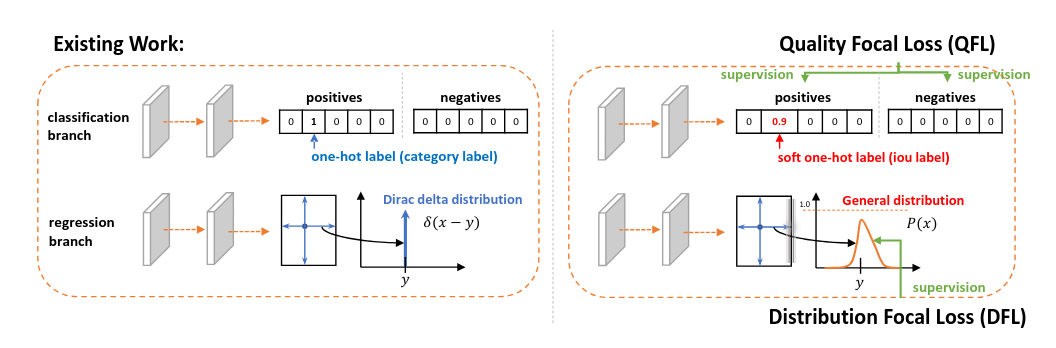

## Выводы

1. `YOLOv8` — это логическое развитие идей, заложенных в предыдущих версиях семейства YOLO (You Only Look Once), но с более глубокими архитектурными изменениями и оптимизациями. Модель разрабатывалась компанией `Ultralytics` и стала одной из наиболее гибких и эффективных реализаций YOLO к моменту своего выхода.

2. `YOLOv8` сохраняет общую структуру `«Backbone → Neck → Head»`, но обновляет каждый компонент:

`Backbone`:
Использует блоки `C2f (Cross-Stage Partial Fusion)`и они обеспечивают лучшее сохранение информации при меньшем числе параметров.

`Neck`:
Реализует `SPPF (Spatial Pyramid Pooling – Fast)`, обеспечивая агрегацию признаков разных масштабов без избыточных вычислений.

`Head`:
`YOLOv8` переходит от `anchor-based` к `anchor-free` детекции. Это упрощает обучение, повышает устойчивость и снижает число гиперпараметров.

3. `YOLOv8` показывает значительный прирост:
- по точности (mAP) — за счёт улучшенной головы и новых функций потерь;
- по скорости инференса — благодаря оптимизированной структуре и легковесным операциям;
- по гибкости — поддерживает классификацию, сегментацию и детекцию в единой архитектуре.